# Speech Emotion Recognition using the RAVDESS AND TESS dataset

In [4]:
# !pip install librosa
# !pip install matplotlib

Loading one audio file from the drive using librosa.
Librosa loads the audio file as a floating point time series.

In [57]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('Audio_Song_Actors_01-24\\Actor_01/03-02-01-01-01-01-01.wav')

Plotting the audio file which was just loaded by librosa using waveplot function of librosa.This Function Plots the amplitude envelope of a waveform.

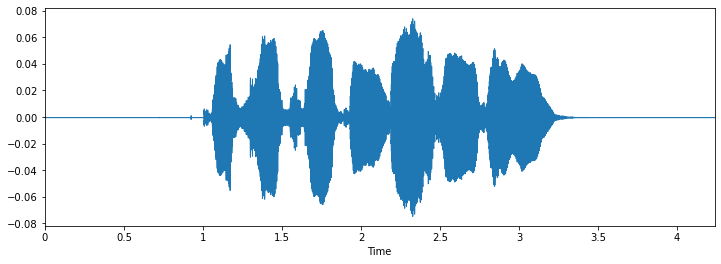

In [58]:
# % pylab inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

# Load all files

We will create our numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file (see the introductory section of this notebook to see the naming convention of the files of this dataset).

In [59]:
import time
import os
import numpy as np
path = 'Audio_Song_Actors_01-24/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
            X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            file = int(file[7:8]) - 1 
            arr = mfccs, file
            lst.append(arr)
          # If the file is not valid, skip it
        except ValueError:
            continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 297.16834712028503 seconds ---


In [60]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [61]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((2452, 40), (2452,))

In [62]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = 'C:\\Users\\ck kalyani\\OneDrive\\Desktop\\deepLearning\\dataset_features'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [63]:
# Loading saved models
import joblib
X = joblib.load('dataset_features/X.joblib')
y = joblib.load('dataset_features/y.joblib')

# Decision Tree Classifier

To make a first attempt in accomplishing this classification task I chose a decision tree:

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [65]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
dtree = DecisionTreeClassifier()

In [67]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [68]:
predictions = dtree.predict(X_test)

In [69]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.40      0.42      0.41        59
           1       0.61      0.61      0.61       131
           2       0.46      0.48      0.47       128
           3       0.41      0.38      0.39       123
           4       0.55      0.54      0.54       121
           5       0.49      0.48      0.49       125
           6       0.35      0.31      0.33        59
           7       0.33      0.39      0.36        64

    accuracy                           0.47       810
   macro avg       0.45      0.45      0.45       810
weighted avg       0.47      0.47      0.47       810



# Neural network

In [70]:
import numpy as np
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [71]:
x_traincnn.shape, x_testcnn.shape

((1642, 40, 1), (810, 40, 1))

In [72]:
# !pip install keras

In [39]:
# !pip install tensorflow

In [73]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

C:\Users\ck kalyani\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 64)            384       
_________________________________________________________________
activation (Activation)      (None, 40, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0

In [74]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [75]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
103/103 [==============================] - 5s 15ms/step - loss: 6.6446 - accuracy: 0.1118 - val_loss: 2.3356 - val_accuracy: 0.1531
Epoch 2/200
103/103 [==============================] - 1s 7ms/step - loss: 4.4264 - accuracy: 0.1365 - val_loss: 2.3213 - val_accuracy: 0.1605
Epoch 3/200
103/103 [==============================] - 1s 7ms/step - loss: 3.7178 - accuracy: 0.1435 - val_loss: 2.1580 - val_accuracy: 0.1815
Epoch 4/200
103/103 [==============================] - 1s 8ms/step - loss: 3.0540 - accuracy: 0.1698 - val_loss: 1.9591 - val_accuracy: 0.2148
Epoch 5/200
103/103 [==============================] - 1s 8ms/step - loss: 2.7401 - accuracy: 0.1699 - val_loss: 2.0720 - val_accuracy: 0.1654
Epoch 6/200
103/103 [==============================] - 1s 7ms/step - loss: 2.5385 - accuracy: 0.1989 - val_loss: 1.9290 - val_accuracy: 0.2481
Epoch 7/200
103/103 [==============================] - 1s 7ms/step - loss: 2.3700 - accuracy: 0.1882 - val_loss: 1.8429 - val_accuracy: 0.276

Epoch 58/200
103/103 [==============================] - 1s 8ms/step - loss: 1.3716 - accuracy: 0.4799 - val_loss: 1.3259 - val_accuracy: 0.5148
Epoch 59/200
103/103 [==============================] - 1s 8ms/step - loss: 1.3983 - accuracy: 0.4633 - val_loss: 1.3224 - val_accuracy: 0.5136
Epoch 60/200
103/103 [==============================] - 1s 8ms/step - loss: 1.3705 - accuracy: 0.4776 - val_loss: 1.3081 - val_accuracy: 0.5432
Epoch 61/200
103/103 [==============================] - 1s 7ms/step - loss: 1.3241 - accuracy: 0.4956 - val_loss: 1.3130 - val_accuracy: 0.5272
Epoch 62/200
103/103 [==============================] - 1s 8ms/step - loss: 1.3481 - accuracy: 0.4739 - val_loss: 1.3062 - val_accuracy: 0.5432
Epoch 63/200
103/103 [==============================] - 1s 7ms/step - loss: 1.2917 - accuracy: 0.5205 - val_loss: 1.2936 - val_accuracy: 0.5370
Epoch 64/200
103/103 [==============================] - 1s 8ms/step - loss: 1.2854 - accuracy: 0.5190 - val_loss: 1.3239 - val_accuracy:

Epoch 115/200
103/103 [==============================] - 1s 8ms/step - loss: 1.0828 - accuracy: 0.5800 - val_loss: 1.1239 - val_accuracy: 0.5889
Epoch 116/200
103/103 [==============================] - 1s 7ms/step - loss: 1.0557 - accuracy: 0.6169 - val_loss: 1.1279 - val_accuracy: 0.5741
Epoch 117/200
103/103 [==============================] - 1s 8ms/step - loss: 1.0421 - accuracy: 0.6264 - val_loss: 1.1039 - val_accuracy: 0.6037
Epoch 118/200
103/103 [==============================] - 1s 9ms/step - loss: 1.0491 - accuracy: 0.6247 - val_loss: 1.1269 - val_accuracy: 0.5864
Epoch 119/200
103/103 [==============================] - 1s 10ms/step - loss: 1.0143 - accuracy: 0.6423 - val_loss: 1.1109 - val_accuracy: 0.5926
Epoch 120/200
103/103 [==============================] - 1s 8ms/step - loss: 1.0388 - accuracy: 0.6170 - val_loss: 1.1155 - val_accuracy: 0.5914
Epoch 121/200
103/103 [==============================] - 1s 7ms/step - loss: 1.0110 - accuracy: 0.6294 - val_loss: 1.0971 - val_a

103/103 [==============================] - 1s 7ms/step - loss: 0.8713 - accuracy: 0.6727 - val_loss: 1.0125 - val_accuracy: 0.6321
Epoch 172/200
103/103 [==============================] - 1s 8ms/step - loss: 0.8909 - accuracy: 0.6615 - val_loss: 1.0231 - val_accuracy: 0.6160
Epoch 173/200
103/103 [==============================] - 1s 8ms/step - loss: 0.8226 - accuracy: 0.6982 - val_loss: 1.0069 - val_accuracy: 0.6296
Epoch 174/200
103/103 [==============================] - 1s 11ms/step - loss: 0.8394 - accuracy: 0.6903 - val_loss: 1.0034 - val_accuracy: 0.6272
Epoch 175/200
103/103 [==============================] - 1s 10ms/step - loss: 0.8379 - accuracy: 0.6999 - val_loss: 0.9747 - val_accuracy: 0.6506
Epoch 176/200
103/103 [==============================] - 1s 12ms/step - loss: 0.8363 - accuracy: 0.6906 - val_loss: 0.9859 - val_accuracy: 0.6198
Epoch 177/200
103/103 [==============================] - 1s 7ms/step - loss: 0.7932 - accuracy: 0.7064 - val_loss: 0.9891 - val_accuracy: 0.6

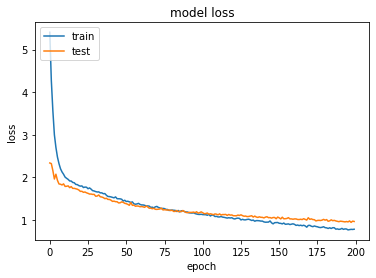

In [76]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

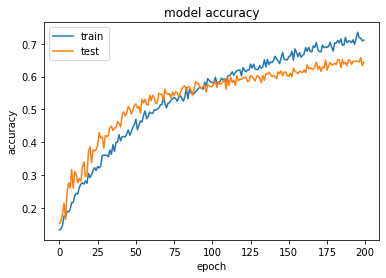

In [77]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
predictions = model.predict_classes(x_testcnn)

C:\Users\ck kalyani\anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [79]:
predictions

array([2, 2, 3, 1, 1, 1, 0, 4, 4, 4, 1, 6, 5, 2, 1, 2, 5, 4, 4, 2, 6, 4,
       3, 1, 6, 2, 5, 6, 7, 7, 4, 6, 3, 4, 0, 3, 1, 3, 4, 3, 1, 3, 2, 3,
       2, 4, 3, 3, 5, 3, 3, 3, 6, 0, 2, 4, 5, 0, 5, 7, 1, 3, 5, 3, 0, 5,
       2, 4, 0, 3, 4, 6, 6, 5, 3, 2, 2, 0, 5, 3, 6, 3, 3, 0, 4, 4, 0, 4,
       5, 5, 1, 3, 4, 2, 2, 3, 5, 5, 4, 0, 6, 1, 1, 7, 5, 2, 7, 2, 5, 2,
       7, 4, 4, 5, 1, 1, 1, 1, 7, 1, 3, 1, 6, 6, 2, 2, 3, 2, 2, 3, 3, 0,
       6, 7, 0, 4, 3, 7, 7, 1, 3, 1, 3, 5, 4, 2, 1, 1, 2, 4, 6, 5, 6, 0,
       6, 3, 3, 4, 5, 4, 4, 1, 4, 5, 3, 0, 6, 2, 3, 1, 3, 2, 1, 5, 1, 5,
       1, 7, 7, 2, 3, 1, 1, 2, 0, 6, 1, 4, 7, 1, 3, 3, 5, 3, 0, 3, 1, 0,
       4, 1, 1, 5, 3, 3, 7, 4, 7, 6, 3, 5, 0, 3, 3, 3, 4, 0, 2, 1, 1, 2,
       6, 3, 5, 3, 3, 5, 1, 1, 2, 4, 0, 7, 5, 4, 2, 0, 4, 5, 5, 3, 3, 5,
       5, 5, 3, 0, 4, 5, 3, 3, 1, 5, 2, 4, 1, 4, 7, 2, 5, 0, 3, 1, 2, 1,
       1, 3, 2, 2, 7, 7, 1, 6, 6, 2, 1, 2, 0, 0, 2, 1, 4, 7, 5, 1, 6, 5,
       3, 3, 5, 0, 6, 0, 1, 1, 5, 6, 6, 5, 5, 4, 2,

In [80]:
y_test

array([2, 2, 3, 1, 1, 1, 1, 2, 4, 4, 0, 0, 5, 2, 1, 3, 2, 4, 5, 3, 6, 4,
       0, 1, 6, 4, 2, 0, 7, 7, 4, 4, 3, 7, 4, 3, 1, 3, 4, 3, 3, 5, 2, 2,
       7, 4, 5, 3, 6, 3, 1, 6, 6, 3, 1, 4, 5, 0, 5, 2, 1, 3, 5, 3, 1, 3,
       2, 4, 6, 3, 4, 2, 6, 5, 5, 2, 2, 0, 5, 3, 7, 3, 3, 1, 4, 4, 0, 4,
       3, 5, 1, 5, 4, 2, 2, 1, 3, 5, 4, 7, 6, 2, 1, 7, 3, 2, 7, 2, 3, 4,
       7, 4, 4, 5, 1, 1, 0, 1, 7, 1, 2, 1, 6, 4, 2, 2, 3, 2, 2, 3, 5, 0,
       4, 6, 0, 7, 3, 7, 7, 1, 5, 1, 2, 7, 4, 4, 5, 2, 2, 4, 6, 7, 7, 2,
       6, 5, 3, 6, 2, 4, 4, 1, 4, 4, 3, 1, 6, 0, 5, 1, 5, 2, 1, 5, 1, 2,
       1, 7, 2, 2, 6, 1, 2, 2, 1, 1, 1, 4, 7, 1, 3, 3, 5, 3, 0, 5, 1, 0,
       4, 1, 1, 3, 3, 3, 7, 4, 3, 4, 3, 4, 1, 0, 5, 3, 5, 0, 2, 1, 1, 2,
       6, 1, 5, 3, 4, 2, 3, 0, 2, 4, 3, 5, 5, 4, 2, 7, 4, 5, 3, 3, 0, 7,
       1, 5, 3, 0, 4, 3, 3, 3, 2, 5, 2, 4, 2, 4, 3, 2, 5, 0, 3, 4, 5, 3,
       1, 3, 1, 5, 2, 7, 1, 7, 4, 1, 1, 2, 0, 0, 2, 1, 4, 5, 5, 2, 6, 5,
       5, 3, 3, 0, 4, 0, 2, 1, 5, 6, 6, 5, 1, 4, 2,

In [81]:
new_Ytest = y_test.astype(int)

In [82]:
new_Ytest

array([2, 2, 3, 1, 1, 1, 1, 2, 4, 4, 0, 0, 5, 2, 1, 3, 2, 4, 5, 3, 6, 4,
       0, 1, 6, 4, 2, 0, 7, 7, 4, 4, 3, 7, 4, 3, 1, 3, 4, 3, 3, 5, 2, 2,
       7, 4, 5, 3, 6, 3, 1, 6, 6, 3, 1, 4, 5, 0, 5, 2, 1, 3, 5, 3, 1, 3,
       2, 4, 6, 3, 4, 2, 6, 5, 5, 2, 2, 0, 5, 3, 7, 3, 3, 1, 4, 4, 0, 4,
       3, 5, 1, 5, 4, 2, 2, 1, 3, 5, 4, 7, 6, 2, 1, 7, 3, 2, 7, 2, 3, 4,
       7, 4, 4, 5, 1, 1, 0, 1, 7, 1, 2, 1, 6, 4, 2, 2, 3, 2, 2, 3, 5, 0,
       4, 6, 0, 7, 3, 7, 7, 1, 5, 1, 2, 7, 4, 4, 5, 2, 2, 4, 6, 7, 7, 2,
       6, 5, 3, 6, 2, 4, 4, 1, 4, 4, 3, 1, 6, 0, 5, 1, 5, 2, 1, 5, 1, 2,
       1, 7, 2, 2, 6, 1, 2, 2, 1, 1, 1, 4, 7, 1, 3, 3, 5, 3, 0, 5, 1, 0,
       4, 1, 1, 3, 3, 3, 7, 4, 3, 4, 3, 4, 1, 0, 5, 3, 5, 0, 2, 1, 1, 2,
       6, 1, 5, 3, 4, 2, 3, 0, 2, 4, 3, 5, 5, 4, 2, 7, 4, 5, 3, 3, 0, 7,
       1, 5, 3, 0, 4, 3, 3, 3, 2, 5, 2, 4, 2, 4, 3, 2, 5, 0, 3, 4, 5, 3,
       1, 3, 1, 5, 2, 7, 1, 7, 4, 1, 1, 2, 0, 0, 2, 1, 4, 5, 5, 2, 6, 5,
       5, 3, 3, 0, 4, 0, 2, 1, 5, 6, 6, 5, 1, 4, 2,

In [83]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.71      0.63        59
           1       0.77      0.76      0.76       131
           2       0.75      0.56      0.64       128
           3       0.54      0.66      0.59       123
           4       0.77      0.69      0.73       121
           5       0.63      0.63      0.63       125
           6       0.48      0.51      0.49        59
           7       0.56      0.55      0.55        64

    accuracy                           0.64       810
   macro avg       0.63      0.63      0.63       810
weighted avg       0.66      0.64      0.65       810



In [84]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[42  5  2  7  0  1  2  0]
 [12 99  3 10  0  5  2  0]
 [ 2 13 72 10  7 11  6  7]
 [ 4  7  6 81  1 15  4  5]
 [ 4  2  4  8 84  5  9  5]
 [ 2  1  4 27  8 79  0  4]
 [ 6  2  1  4  4  5 30  7]
 [ 2  0  4  3  5  5 10 35]]


In [85]:
model.save('testing10_model.h5')
print("MODEL SAVED")

MODEL SAVED


In [88]:
new_model=keras.models.load_model('testing10_model.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 40, 64)            384       
_________________________________________________________________
activation_4 (Activation)    (None, 40, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 128)          

In [89]:
loss, acc = new_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

26/26 [==============================] - 1s 3ms/step - loss: 0.9619 - accuracy: 0.6444
Restored model, accuracy: 64.44%


In [ ]:
less data less accuracy
but appudu 80% accuracy unde kada
it will depends on what data we provided but u will get 